In [2]:
import numpy as np 
import pandas as pd 

import torch
import torchvision
from torchvision import transforms, models
import matplotlib.pyplot as plt
import time
import copy

import shutil 
from tqdm import tqdm

import os
from google.colab import files
uploaded = files.upload()

Saving plates.zip to plates.zip


In [277]:
#!unzip -q "plates.zip"
data_root = 'plates'

#data_root = '../plates'
print(os.listdir(data_root))

['.DS_Store', 'test', 'train']


In [278]:
!ls

__MACOSX  plates  plates.zip  sample_data  submission.csv


In [288]:
train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 5 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 3126.52it/s]


In [289]:
!ls train

cleaned  dirty


### Добавляем трансформации: RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, RandomPerspective для трейновой выборки, затем с помощью RandomSampler увеличиваем размер выборки. Таким образом, получаем варианты картинок с различными флипами и фильтрами.

In [0]:
train_transforms = transforms.Compose([
    transforms.RandomCrop(200),
    transforms.ColorJitter(contrast=0.4, brightness = 0.4),
    transforms.RandomVerticalFlip(p = 0.7),
    transforms.RandomHorizontalFlip(p = 0.7),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.CenterCrop(200),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms) 
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 10
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, sampler = torch.utils.data.RandomSampler(train_dataset, replacement=True, num_samples=120), batch_size=batch_size, shuffle=False, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [291]:
len(train_dataloader), len(train_dataset)

(12, 36)

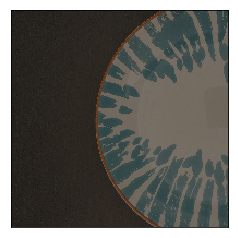

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


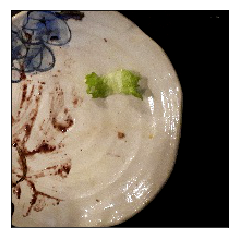

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


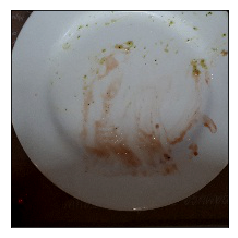

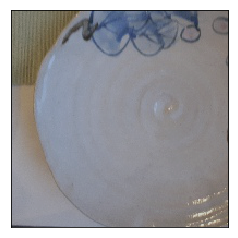

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


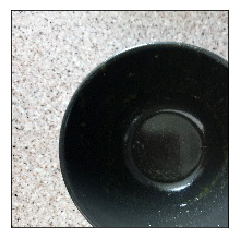

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


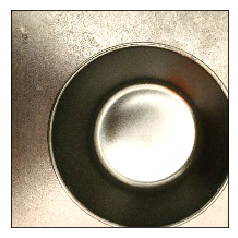

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


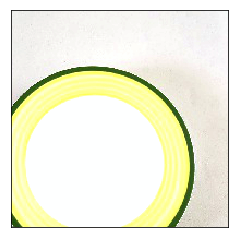

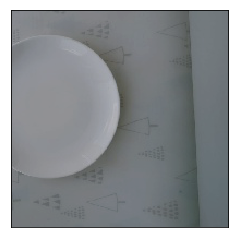

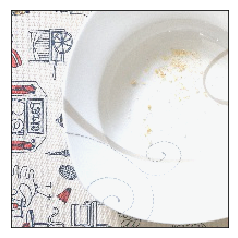

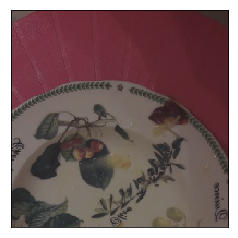

In [292]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
for i in range(10):
  plt.imshow(X_batch[i].permute(1, 2, 0).numpy() * std + mean)
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [0]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

In [0]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

### Меняем сеть на resnext50_32x4d. Немного меняем параметры Adam.

In [0]:
model = models.resnext50_32x4d(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3.0e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

In [296]:
train_model(model, loss, optimizer, scheduler, num_epochs=10);

Epoch 0/9:
train Loss: 0.7059 Acc: 0.5500
val Loss: 0.6523 Acc: 0.6500
Epoch 1/9:
train Loss: 0.6187 Acc: 0.6667
val Loss: 0.7167 Acc: 0.5167
Epoch 2/9:
train Loss: 0.5911 Acc: 0.7167
val Loss: 0.5835 Acc: 0.6667
Epoch 3/9:
train Loss: 0.5697 Acc: 0.6333
val Loss: 0.5415 Acc: 0.7167
Epoch 4/9:
train Loss: 0.5328 Acc: 0.7833
val Loss: 0.5266 Acc: 0.5833
Epoch 5/9:
train Loss: 0.4589 Acc: 0.8500
val Loss: 0.5581 Acc: 0.6833
Epoch 6/9:
train Loss: 0.4591 Acc: 0.8417
val Loss: 0.5333 Acc: 0.6833
Epoch 7/9:
train Loss: 0.4500 Acc: 0.8500
val Loss: 0.4822 Acc: 0.7333
Epoch 8/9:
train Loss: 0.4235 Acc: 0.8583
val Loss: 0.4812 Acc: 0.7333
Epoch 9/9:
train Loss: 0.4406 Acc: 0.8417
val Loss: 0.4539 Acc: 0.7333


In [297]:
data_root = 'plates'
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [0]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [299]:
!ls test

unknown


In [300]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 75/75 [02:31<00:00,  1.69s/it]


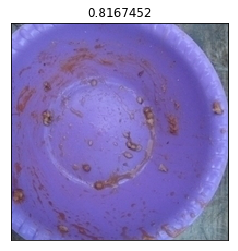

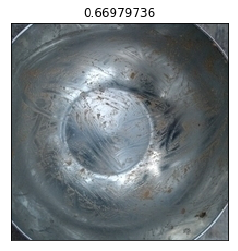

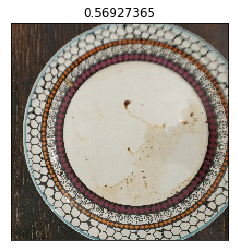

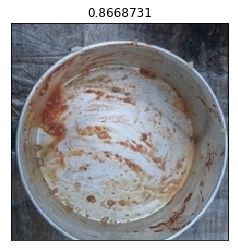

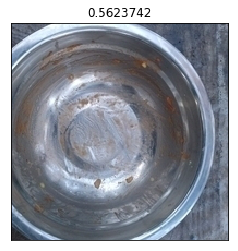

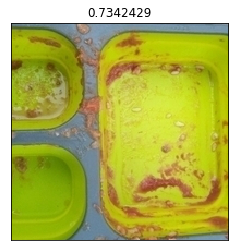

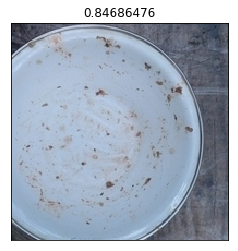

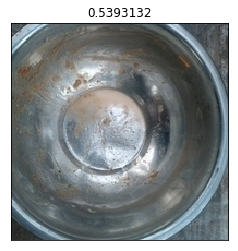

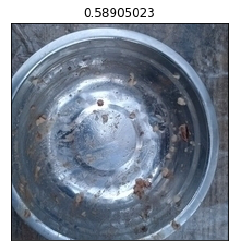

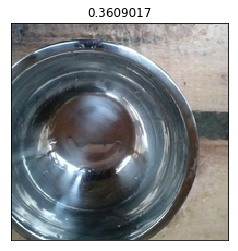

In [301]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [0]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [303]:
submission_df['label'].describe()

count    744.000000
mean       0.612595
std        0.168412
min        0.145075
25%        0.487198
50%        0.628172
75%        0.747277
max        0.941888
Name: label, dtype: float64

In [304]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > np.percentile(submission_df['label'], 30) else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=15)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty
0006,dirty
0007,dirty
0008,dirty


In [0]:
!rm -rf train val test

In [306]:
submission_df['label'].value_counts()

dirty      521
cleaned    223
Name: label, dtype: int64

In [0]:
submission_df.to_csv('submission.csv')

In [0]:
files.download('submission.csv')